In [1]:
import sys
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import os

# --- Utility Functions ---
def one_hot_encode_dna_padded(sequence, max_len):
    """One-hot encodes a DNA sequence with padding."""
    mapping = {'A': [1,0,0,0], 'C': [0,1,0,0], 'G': [0,0,1,0], 'T': [0,0,0,1]}
    padding = [0,0,0,0]
    encoded_sequence = []
    for i in range(max_len):
        if i < len(sequence):
            nucleotide = sequence[i].upper()
            encoded_sequence.append(mapping.get(nucleotide, padding))
        else:
            encoded_sequence.append(padding)
    return np.array(encoded_sequence)

In [2]:
# --- 1. Data Loading ---

# Add the project source directory to the Python path to import amr_utility
src_path = r"C:\Users\RASSUL\Desktop\TUBS\4 Seminar (Deep Learning For Molecular Biology)\seminar-dlmb-2024-winter-public\src"
sys.path.append(src_path)

from amr.amr_utility import load_gene_data

# Define paths
processed_data_dir = r"C:\Users\RASSUL\Desktop\TUBS\4 Seminar (Deep Learning For Molecular Biology)\seminar-dlmb-2024-winter-public\data\ds1"

# Load the training data
print("Loading training data...")
ds_train = load_gene_data(processed_data_dir, "Staphylococcus_aureus_cefoxitin", "pbp4")
train_sequences = [x[1] for x in ds_train["train"]]
train_labels = [int(x[2]) for x in ds_train["train"]]
print(f"Loaded {len(train_sequences)} training sequences.")

# Load the test data
print("Loading test data...")
ds_test = load_gene_data(processed_data_dir, "Staphylococcus_aureus_cefoxitin", "pbp4")
test_sequences = [x[1] for x in ds_test["test"]]
test_labels = [int(x[2]) for x in ds_test["test"]]
print(f"Loaded {len(test_sequences)} test sequences.")

Loading training data...
Loaded 135 training sequences.
Loading test data...
Loaded 15 test sequences.


In [3]:
# --- 2. Data Preparation ---

# Determine max_length from training sequences to ensure consistency
max_length = max(len(seq) for seq in train_sequences)

X_train_full = np.array([one_hot_encode_dna_padded(seq, max_length) for seq in train_sequences])
y_train_full = np.array(train_labels)

X_test = np.array([one_hot_encode_dna_padded(seq, max_length) for seq in test_sequences])
y_test = np.array(test_labels)

# Split the full training data to create a validation set for early stopping
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=77, stratify=y_train_full
)

print(f"\nTraining data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Test data shape: {X_test.shape}")


Training data shape: (108, 1296, 4)
Validation data shape: (27, 1296, 4)
Test data shape: (15, 1296, 4)


In [4]:
# --- 3. Class Weighting for Imbalance ---
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train_full),
    y=y_train_full
)
class_weight_dict = {i : class_weights[i] for i, w in enumerate(class_weights)}
print("\nCalculated Class Weights to handle data imbalance:", class_weight_dict)


Calculated Class Weights to handle data imbalance: {0: 1.8243243243243243, 1: 0.6887755102040817}


In [5]:
# --- 4. Build the LSTM Model ---

model = Sequential([
    Input(shape=(max_length, 4)),
    LSTM(64, return_sequences=True),
    Dropout(0.3),
    LSTM(32, return_sequences=False),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 1296, 64)            │          17,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1296, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,169 (121.75 KB)

 Trainable params: 31,169 (121.75 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# --- 5. Train the Model with Class Weights ---

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

print("\n--- Starting Model Training with Class Weights---")
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1,
    class_weight=class_weight_dict
)
print("--- Model Training Finished ---\n")


--- Starting Model Training with Class Weights---
Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 813ms/step - accuracy: 0.4169 - loss: 0.6859 - val_accuracy: 0.5185 - val_loss: 0.6907
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 677ms/step - accuracy: 0.4896 - loss: 0.6943 - val_accuracy: 0.5185 - val_loss: 0.7000
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 649ms/step - accuracy: 0.4057 - loss: 0.6840 - val_accuracy: 0.2593 - val_loss: 0.7079
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 655ms/step - accuracy: 0.3975 - loss: 0.6823 - val_accuracy: 0.2593 - val_loss: 0.7133
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 639ms/step - accuracy: 0.5203 - loss: 0.6836 - val_accuracy: 0.5185 - val_loss: 0.7145
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 631ms/step - accuracy: 0.5299 - loss: 0.6883 - val_accuracy: 0.5185 - val_loss: 0.7192
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 637ms/step - accuracy: 0.5718 - loss: 0.6417 - val_accuracy: 0.5185 - val_loss: 0.7060
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 658ms/step - accurac


--- Evaluating Model on Test Data ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step
Test Loss: 0.6867
Test Accuracy: 0.7333 (Note: Accuracy is misleading for imbalanced data)

--- Classification Report ---
                   precision    recall  f1-score   support

Non-Resistant (0)       0.43      1.00      0.60         3
    Resistant (1)       1.00      0.67      0.80        12

         accuracy                           0.73        15
        macro avg       0.71      0.83      0.70        15
     weighted avg       0.89      0.73      0.76        15

--- Confusion Matrix ---


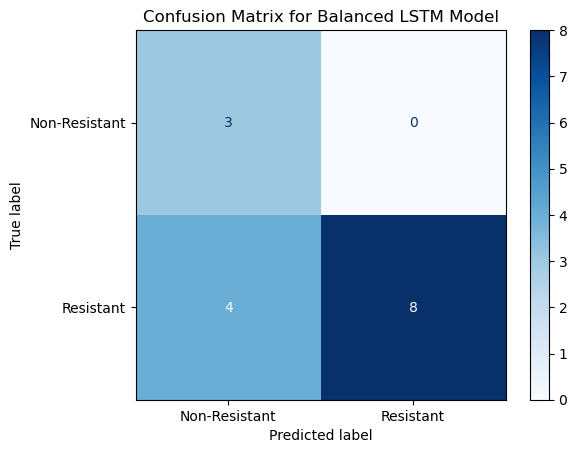

In [7]:
# --- 6. Evaluate the Model with Better Metrics ---
print("\n--- Evaluating Model on Test Data ---")
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype("int32")

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f} (Note: Accuracy is misleading for imbalanced data)\n")

# --- Classification Report ---
print("--- Classification Report ---")
print(classification_report(y_test, y_pred, target_names=['Non-Resistant (0)', 'Resistant (1)']))

# --- Confusion Matrix ---
print("--- Confusion Matrix ---")
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Resistant', 'Resistant'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Balanced LSTM Model')
plt.savefig("grafik2.png")
plt.show()

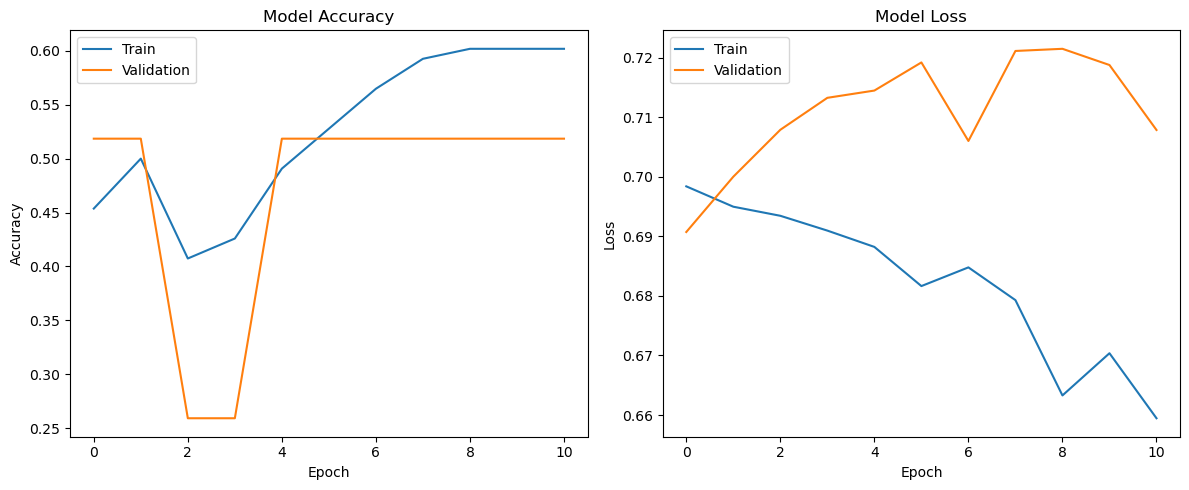

In [8]:
# --- 7. Plot Training History ---

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()
